In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, random_split
import torch.nn.functional as F
import sys
import os
import pickle
import pandas as pd
from torch.utils.tensorboard import SummaryWriter
parent_dir = os.path.abspath("../")
sys.path.append(parent_dir)
parent_dir = os.path.abspath("../utils/")
sys.path.append(parent_dir)
from pathlib import Path
from tqdm import tqdm
# from attention_visualisation import run_attention_dashboard, run_model_dashboard

## Analysing Training and Testing Results

In [7]:
base_path = Path("experiments/training")
train_losses = pd.DataFrame()
val_losses = pd.DataFrame()
sentences = {}
exp_string = lambda x: f"hindi_model_{x}_256_2048_2_2"
for exp in [1, 2, 4, 8, 16, 32, 64, 128, 256]:
    spec_string = exp_string(exp)
    # sentences = pd.read_csv(base_path / f"{spec_string}_sentences.txt", header=None, nrows=300)
    train_loss = pd.read_csv(base_path / f"{spec_string}_train_loss.txt", header=None, nrows=300)
    val_loss = pd.read_csv(base_path / f"{spec_string}_val_loss.txt", header=None, nrows=300)
    train_loss['heads'] = exp
    val_loss['heads'] = exp

    train_losses = pd.concat([train_losses, train_loss], ignore_index=True)
    val_losses = pd.concat([val_losses, val_loss], ignore_index=True)


In [8]:
# Rename the columns
train_losses.columns = ['loss_value', 'perplexity', 'accuracy', 'heads']
train_losses['loss_value'] = train_losses['loss_value'].str.replace('(', '').astype(float)
train_losses['perplexity'] = train_losses['perplexity'].str.extract(r'float64\(([^)]+)\)').astype(float)
train_losses['accuracy'] = train_losses['accuracy'].str.replace(')', '').astype(float)

val_losses.columns = ['loss_value', 'perplexity', 'accuracy', 'heads']
val_losses['loss_value'] = val_losses['loss_value'].str.replace('(', '').astype(float)
val_losses['perplexity'] = val_losses['perplexity'].str.extract(r'float64\(([^)]+)\)').astype(float)
val_losses['accuracy'] = val_losses['accuracy'].str.replace(')', '').astype(float)

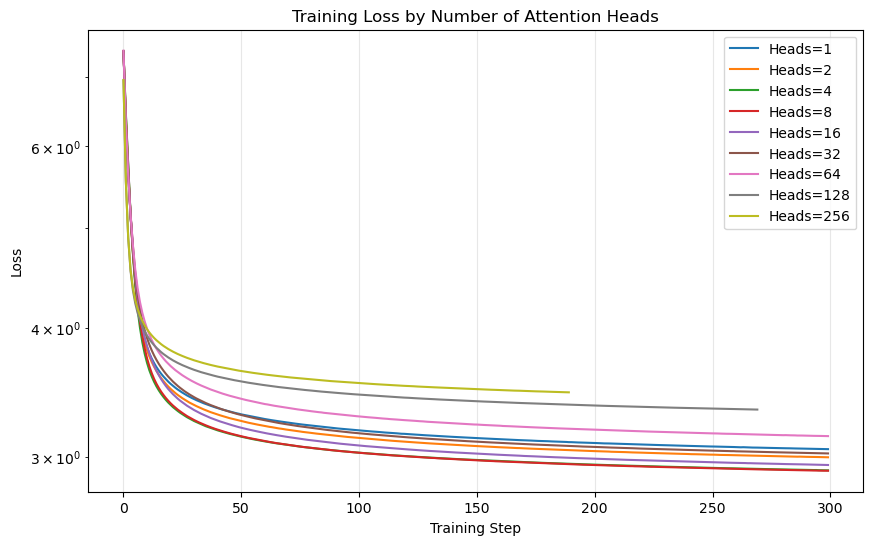

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 6))
for exp_value in sorted(train_losses['heads'].unique()):
    exp_data = train_losses[train_losses['heads'] == exp_value]
    
    # Plot the line for this experiment with a label
    plt.plot(np.arange(len(exp_data['loss_value'])), exp_data['loss_value'], label=f'Heads={exp_value}')

plt.yscale("log")
# Add labels and title
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Training Loss by Number of Attention Heads')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

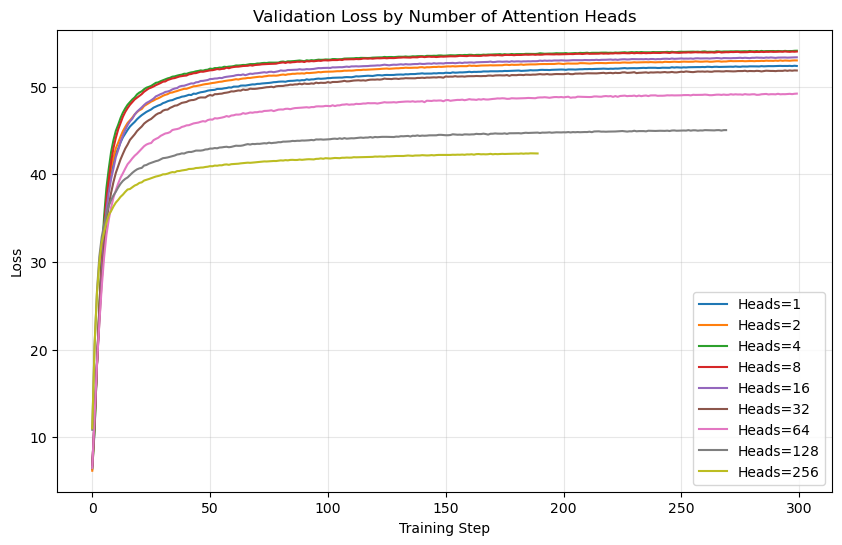

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
for exp_value in sorted(val_losses['heads'].unique()):
    exp_data = val_losses[val_losses['heads'] == exp_value]
    
    # Plot the line for this experiment with a label
    plt.plot(np.arange(len(exp_data['loss_value'])), exp_data['accuracy'], label=f'Heads={exp_value}')

# plt.yscale("log")
# Add labels and title
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.title('Validation Loss by Number of Attention Heads')
plt.legend()
plt.grid(True, alpha=0.3)

# Show the plot
plt.show()

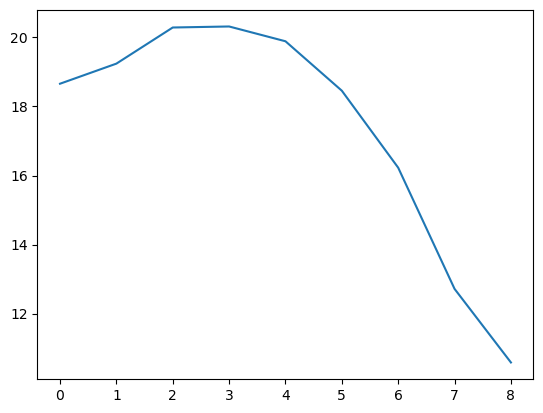

In [12]:
exp = [1, 2, 4, 8, 16, 32, 64, 128, 256]

bleu_all = [18.658923410191438, 19.240758224498947, 20.28723264086618, 20.316938484738877, 19.8884236392137, 18.456417624187825, 16.226719252362493, 12.716272842725653, 10.58487196691237]
plt.plot(bleu_all)

## Ablation Studies

### Why not simple correlation

### Greedy Decoding Analysis

In [15]:
heads = 16
removal_order =[]
bleu_scores_removal = []
results_file = f"experiments/ablation/hindi_model_{heads}_256_2048_2_2_ablation_results.txt"
with open(results_file, 'r') as f:
    lines = f.readlines()
    for line in lines:
        if "Step" in line and "removed" in line and ":" in line:
            # Parse line like "Step 1: removed 5: 19.25"
            parts = line.strip().split(":")
            removed_idx = int(parts[1].split()[1])
            score = float(parts[2].strip())
            
            removal_order.append(removed_idx)
            bleu_scores_removal.append(score)

bleu_all_baselines = [18.658923410191438, 19.240758224498947, 20.28723264086618, 20.316938484738877, 19.8884236392137, 18.456417624187825, 16.226719252362493, 12.716272842725653, 10.58487196691237]


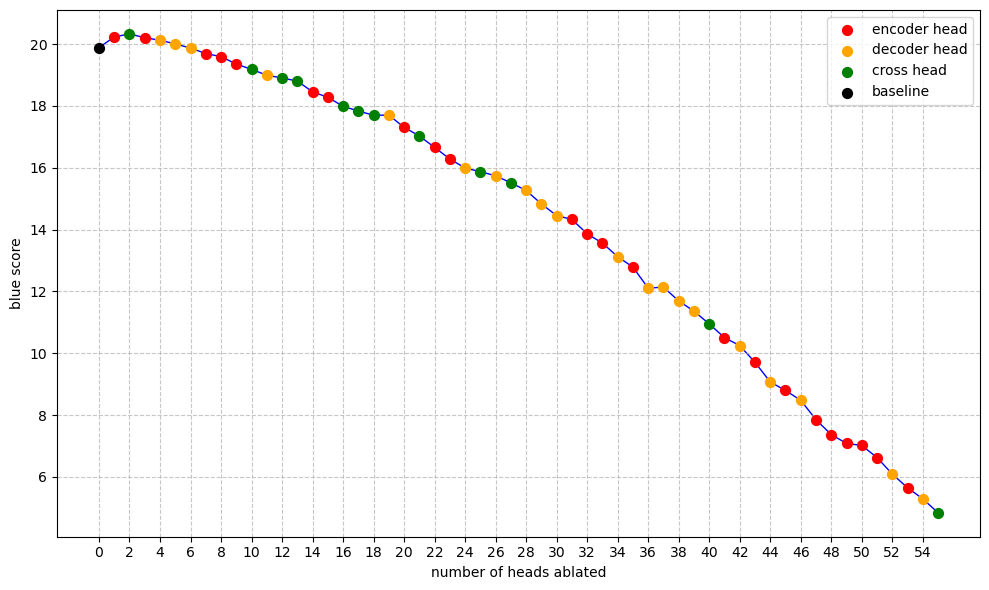

In [16]:
plt.figure(figsize=(10, 6))
indices = range(len(bleu_scores_removal))
plt.plot(range(len(bleu_scores_removal) + 1), [bleu_all_baselines[int(np.log2(heads))]] + bleu_scores_removal, color='blue', linestyle='-', linewidth=1, zorder=1)

x_red, y_red = zip(*[(i + 1, bleu_scores_removal[i]) for i in indices if removal_order[i] < heads * 2]) if any(removal_order[i] < heads * 2 for i in indices) else ([], [])
x_yellow, y_yellow = zip(*[(i + 1, bleu_scores_removal[i]) for i in indices if heads * 2 <= removal_order[i] < heads * 4]) if any(heads * 2 <= removal_order[i] < heads * 4 for i in indices) else ([], [])
x_green, y_green = zip(*[(i + 1, bleu_scores_removal[i]) for i in indices if heads * 4 <= removal_order[i] < heads * 6]) if any(heads * 4 <= removal_order[i] < heads * 6 for i in indices) else ([], [])

plt.scatter(x_red, y_red, color='red', s=50, zorder=2, label='encoder head')
plt.scatter(x_yellow, y_yellow, color='orange', s=50, zorder=2, label='decoder head')
plt.scatter(x_green, y_green, color='green', s=50, zorder=2, label='cross head')
plt.scatter(0, bleu_all_baselines[int(np.log2(heads))], color='black', s=50, zorder=2, label='baseline')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.xticks(range(0, len(bleu_scores_removal) + 1, 2))
plt.xlabel('number of heads ablated')
plt.ylabel('blue score')
plt.tight_layout()
plt.show()